In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyarrow.parquet as pq
import gc
import pywt
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter
from tqdm import tqdm_notebook
import os
from multiprocessing import Pool

import warnings

# Suppress pandas future warnings, I am using different library versions locally
# that do not raise warnings.
warnings.simplefilter(action='ignore', category=FutureWarning)

data_dir = '../input'

In [2]:
print(scipy.__version__)

1.1.0


In [3]:
# 800,000 data points taken over 20 ms
# Grid operates at 50hz, 0.02 * 50 = 1, so 800k samples in 20 milliseconds will capture one complete cycle
n_samples = 800000

# Sample duration is 20 miliseconds
sample_duration = 0.02

# Sample rate is the number of samples in one second
# Sample rate will be 40mhz
sample_rate = n_samples * (1 / sample_duration)

In [4]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [5]:
def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    # scipy version 1.2.0
    #sos = butter(10, low_freq, btype='hp', fs=sample_fs, output='sos')
    
    # scipy version 1.1.0
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

In [10]:
def denoise_signal( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff[0:], wavelet, mode='per' )

In [7]:
def main(x):
    numpeaks = []
    for col in tqdm_notebook(range(x.shape[1])):
        x_hp = high_pass_filter(x.iloc[:,col], low_cutoff=10000, sample_rate=sample_rate)
        x_dn = denoise_signal(x_hp, wavelet='haar', level=1)

        index = pd.Series(x_dn).loc[np.abs(x_dn)>0].index
        for idx in index:
            for i in range(1,maxDistance+1):
                if idx+i < pd.Series(x_dn).shape[0]:
                    if x_dn[idx+i]/(x_dn[idx]+1e-04)<-maxHeightRatio:
                        x_dn[idx:idx+maxTicksRemoval] = 0
        
        numpeaks.append(pd.Series(x_dn).loc[np.abs(x_dn)>0].count())
        numpospeaks.append(pd.Series(x_dn).loc[x_dn>0].count())
        numnegpeaks.append(pd.Series(x_dn).loc[x_dn<0].count())

        peakwidth = []
        for idx in range(numpeaks[col]-1):
            peakwidth.append(pd.Series(x_dn).loc[np.abs(x_dn)>0].index[idx+1] - pd.Series(x_dn).loc[np.abs(x_dn)>0].index[idx])

        if len(peakwidth)==0:
            maxpeakwidth.append(0)
            minpeakwidth.append(0)
            meanpeakwidth.append(0)
        else:
            maxpeakwidth.append(np.max(peakwidth))
            minpeakwidth.append(np.min(peakwidth))
            meanpeakwidth.append(np.mean(peakwidth))

        maxamp.append(x_dn.max())
        minamp.append(x_dn.min())
        meanamp.append(np.mean(x_dn))

        stdampall.append(np.std(pd.Series(x_dn).loc[np.abs(x_dn)>0]))
        stdposall.append(np.std(pd.Series(x_dn).loc[np.abs(x_dn)>0].index))
        stdwidthall.append(np.std(peakwidth))

        stdampq2.append(np.std(pd.Series(x_dn[100001:200000]).loc[np.abs(x_dn[100001:200000])>0]))
        stdposq2.append(np.std(pd.Series(x_dn[100001:200000]).loc[np.abs(x_dn[100001:200000])>0].index))

        numpeaks_q2 = pd.Series(x_dn[100001:200000]).loc[np.abs(x_dn[100001:200000])>0].count()
        peakwidth_q2 = []
        for idx in range(numpeaks_q2-1):
            peakwidth_q2.append(pd.Series(x_dn[100001:200000]).loc[np.abs(x_dn[100001:200000])>0].index[idx+1] 
                                - pd.Series(x_dn[100001:200000]).loc[np.abs(x_dn[100001:200000])>0].index[idx])
        stdwidthq2.append(np.std(peakwidth_q2))

        stdampq3.append(np.std(pd.Series(x_dn[200001:300000]).loc[np.abs(x_dn[200001:300000])>0]))
        stdposq3.append(np.std(pd.Series(x_dn[200001:300000]).loc[np.abs(x_dn[200001:300000])>0].index))

        numpeaks_q3 = pd.Series(x_dn[200001:300000]).loc[np.abs(x_dn[200001:300000])>0].count()
        peakwidth_q3 = []
        for idx in range(numpeaks_q3-1):
            peakwidth_q3.append(pd.Series(x_dn[200001:300000]).loc[np.abs(x_dn[200001:300000])>0].index[idx+1] 
                                - pd.Series(x_dn[200001:300000]).loc[np.abs(x_dn[200001:300000])>0].index[idx])
        stdwidthq3.append(np.std(peakwidth_q3))

        stdampq4.append(np.std(pd.Series(x_dn[300001:400000]).loc[np.abs(x_dn[300001:400000])>0]))
        stdposq4.append(np.std(pd.Series(x_dn[300001:400000]).loc[np.abs(x_dn[300001:400000])>0].index))

        numpeaks_q4 = pd.Series(x_dn[300001:400000]).loc[np.abs(x_dn[300001:400000])>0].count()
        peakwidth_q4 = []
        for idx in range(numpeaks_q4-1):
            peakwidth_q4.append(pd.Series(x_dn[300001:400000]).loc[np.abs(x_dn[300001:400000])>0].index[idx+1] 
                                - pd.Series(x_dn[300001:400000]).loc[np.abs(x_dn[300001:400000])>0].index[idx])
        stdwidthq4.append(np.std(peakwidth_q4))
    return numpeaks

In [8]:
subset_train = pq.read_pandas(data_dir + '/train.parquet', columns=[str(i) for i in range(6)]).to_pandas()

x_hp = high_pass_filter(subset_train.iloc[:, 0], low_cutoff=10000, sample_rate=sample_rate)
x_dn = denoise_signal(subset_train.iloc[:, 0], wavelet='haar', level=1)

In [13]:
x_hp = high_pass_filter(subset_train.iloc[:, 0], low_cutoff=10000, sample_rate=sample_rate)
x_dn = denoise_signal(x_hp, wavelet='haar', level=1)

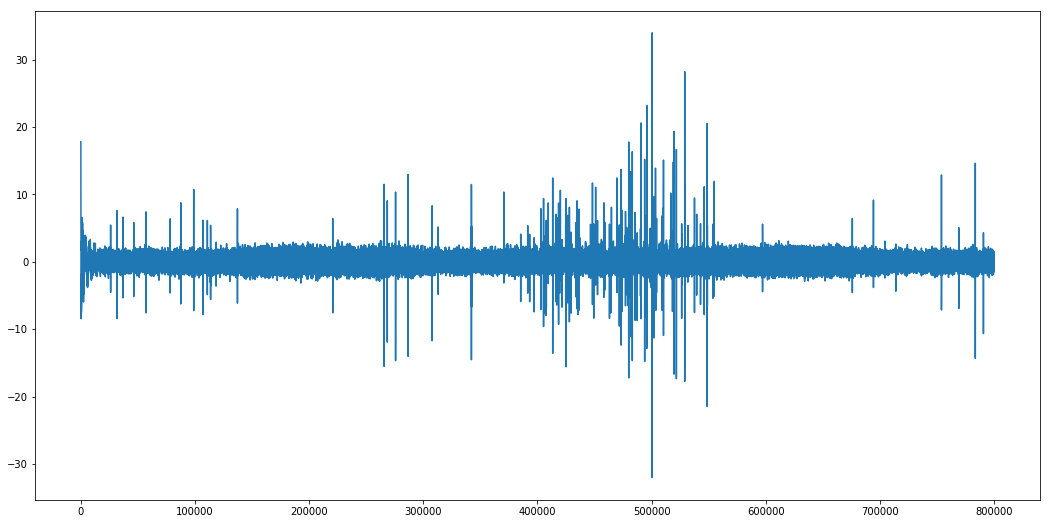

In [14]:
plt.figure(figsize=(18, 9))
plt.plot(x_dn)

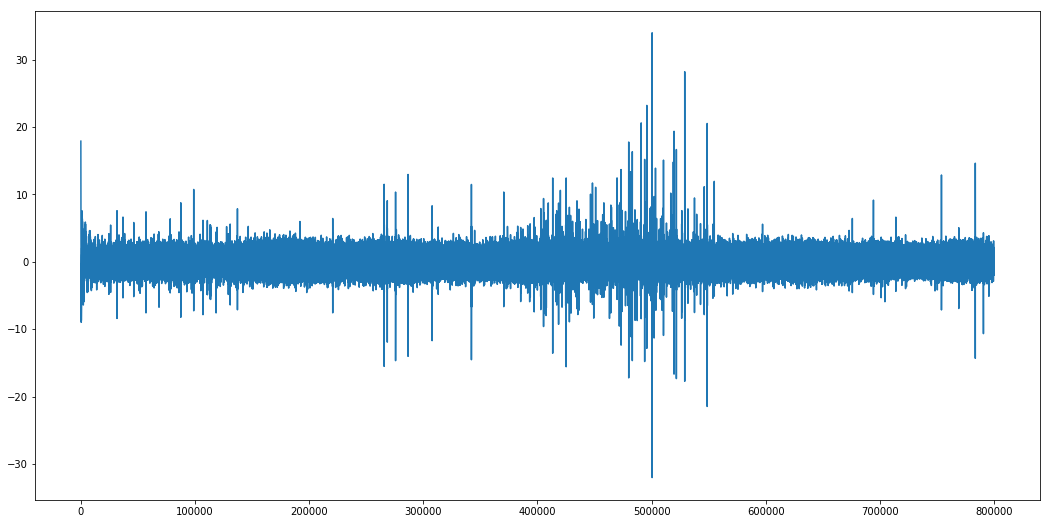

In [10]:
plt.figure(figsize=(18, 9))
plt.plot(x_hp)

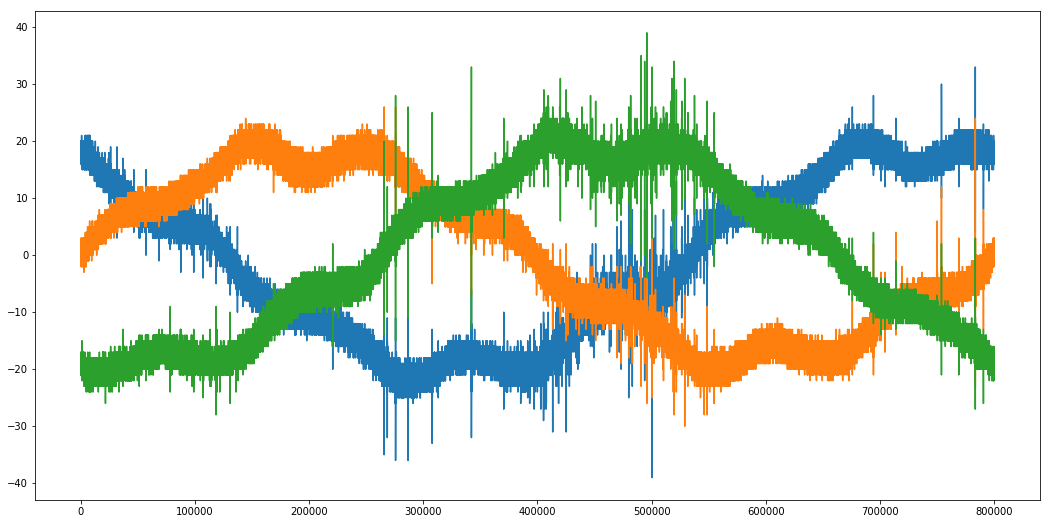

In [11]:
plt.figure(figsize=(18, 9))
plt.plot(subset_train.iloc[:, 0])
plt.plot(subset_train.iloc[:, 1])
plt.plot(subset_train.iloc[:, 2])

In [12]:
pd.Series(x_dn).shape[0]

400000

In [13]:
maxDistance = 10
maxHeightRatio = 0.25
maxTicksRemoval =500

index = pd.Series(x_dn).loc[np.abs(x_dn)>0].index
for idx in index:
    for i in range(1,maxDistance+1):
        if idx+i < pd.Series(x_dn).shape[0]:
            if x_dn[idx+i]/(x_dn[idx]+1e-04)<-maxHeightRatio:
                x_dn[idx:idx+maxTicksRemoval] = 0

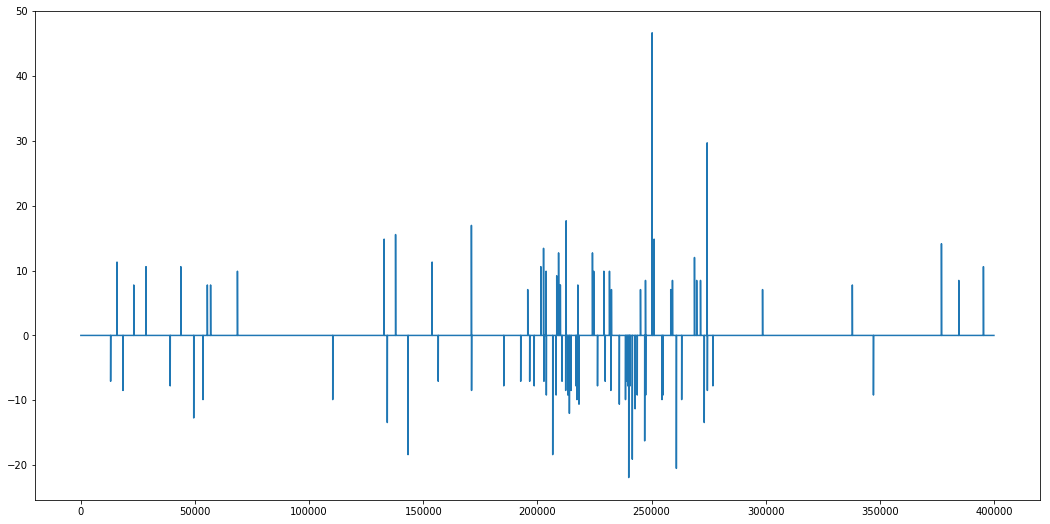

In [14]:
plt.figure(figsize=(18, 9))
plt.plot(x_dn)

In [15]:
def denoise_signal_a( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff[0:], wavelet, mode='per' )

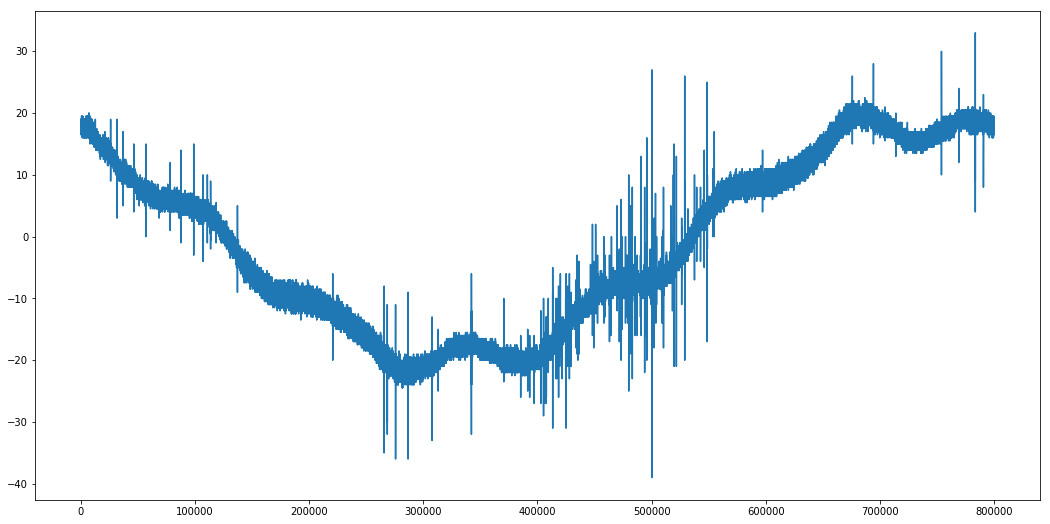

In [16]:
x_dn = denoise_signal_a(subset_train.iloc[:, 0], wavelet='haar', level=1)
plt.figure(figsize=(18, 9))
plt.plot(x_dn)

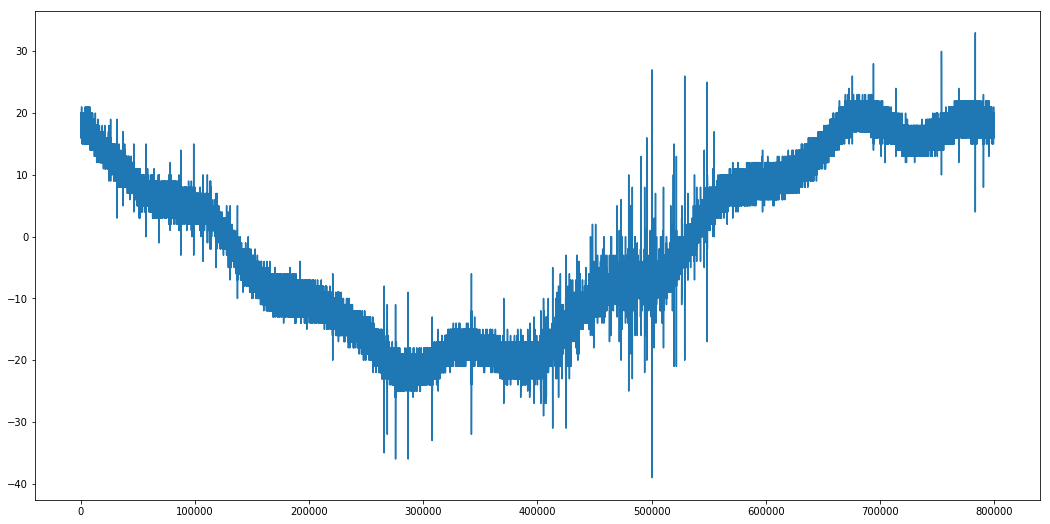

In [17]:
plt.figure(figsize=(18, 9))
plt.plot(subset_train.iloc[:, 0])

In [28]:
maxDistance = 10
maxHeightRatio = 0.25
maxTicksRemoval =500

numpeaks = []
numpospeaks = []
numnegpeaks = []
numpeaks_stack = []

maxpeakwidth = []
minpeakwidth = []
meanpeakwidth = []
maxamp = []
minamp = []
meanamp = []

stdampall = []
stdposall = []
stdwidthall = []

stdampq2 = []
stdposq2 = []
stdwidthq2 = []
stdampq3 = []
stdposq3 = []
stdwidthq3 = []
stdampq4 = []
stdposq4 = []
stdwidthq4 = []

In [29]:
for i in range(10):
    subset_test = pq.read_pandas('../input/test.parquet', columns=[str(i*2000 + j + 8712) for j in range(2000)]).to_pandas()
    numpeaks_stack += main(subset_test)
    gc.collect()

/home/cwademo123/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cwademo123/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cwademo123/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [30]:
len(numpeaks_stack)

20000

In [31]:
numpeaks = np.array(numpeaks_stack)
numpospeaks = np.array(numpospeaks)
numnegpeaks = np.array(numnegpeaks)

maxpeakwidth = np.array(maxpeakwidth)
minpeakwidth = np.array(minpeakwidth)
meanpeakwidth = np.array(meanpeakwidth)
maxamp = np.array(maxamp)
minamp = np.array(minamp)
meanamp = np.array(meanamp)

stdampall = np.array(stdampall)
stdposall = np.array(stdposall)
stdwidthall = np.array(stdwidthall)

stdampq2 = np.array(stdampq2)
stdposq2 = np.array(stdposq2)
stdwidthq2 = np.array(stdwidthq2)
stdampq3 = np.array(stdampq3)
stdposq3 = np.array(stdposq3)
stdwidthq3 = np.array(stdwidthq3)
stdampq4 = np.array(stdampq4)
stdposq4 = np.array(stdposq4)
stdwidthq4 = np.array(stdwidthq4)

In [34]:
np.save('../features/numpeaks_test.npy', numpeaks)
np.save('../features/numpospeaks_test.npy', numpospeaks)
np.save('../features/numnegpeaks_test.npy', numnegpeaks)
np.save('../features/maxpeakwidth_test.npy', maxpeakwidth)
np.save('../features/minpeakwidth_test.npy', minpeakwidth)
np.save('../features/meanpeakwidth_test.npy', meanpeakwidth)
np.save('../features/maxamp_test.npy', maxamp)
np.save('../features/minamp_test.npy', minamp)
np.save('../features/meanamp_test.npy', meanamp)
np.save('../features/stdampall_test.npy', stdampall)
np.save('../features/stdposall_test.npy', stdposall)
np.save('../features/stdwidthall_test.npy', stdwidthall)
np.save('../features/stdampq2_test.npy', stdampq2)
np.save('../features/stdposq2_test.npy', stdposq2)
np.save('../features/stdwidthq2_test.npy', stdwidthq2)
np.save('../features/stdampq3_test.npy', stdampq3)
np.save('../features/stdposq3_test.npy', stdposq3)
np.save('../features/stdwidthq3_test.npy', stdwidthq3)
np.save('../features/stdampq4_test.npy', stdampq4)
np.save('../features/stdposq4_test.npy', stdposq4)
np.save('../features/stdwidthq4_test.npy', stdwidthq4)